In [110]:
import os
import re
import gensim
import pandas as pd

from glob import glob
from pprint import pprint
from gensim import corpora
from nltk.stem.wordnet import WordNetLemmatizer
from vuepoint.vuepoint.stats_pipeline import get_dataframe_stats

In [111]:
def assing_videoid_labels(file_name):
    file_name = re.sub('downloads/', '', str(file_name))
    file_name = re.sub('.json', '', file_name)
    search_query, video_id = file_name.split('/')
    return search_query, video_id

def save_dataset_to_directory(df, dir_name, file_name):
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)
    save_path = dir_name + '/' + file_name + '.csv'
    df.to_csv(save_path)

In [112]:
joined_datasets = []
for file in glob('downloads/thinkpad_review/*.json'):
    corpus = pd.read_json(file, encoding='utf-8', lines=True)
    search_query, video_id = assing_videoid_labels(file)
    corpus['search_query'] = search_query
    corpus['video_id'] = video_id
    joined_datasets.append(corpus)
dataset = pd.concat(joined_datasets, ignore_index=True)
dataset.text.describe()

count       38163
unique      36904
top       Windows
freq          120
Name: text, dtype: object

In [113]:
# get stats of the dataset and trim whitespace & remove colums w/sents less than 10
dataset = get_dataframe_stats(dataset, 'text', min_word_count=10)

# save the joined datasets in directory
prodigy_dir_path = 'prodigy/working_datasets/thinkpad_review'
save_dataset_to_directory(dataset, prodigy_dir_path, file_name='thinkpad_review')
dataset.text.describe()

count                                                 19362
unique                                                19328
top       first thinkpad was released in 1992 the model ...
freq                                                      4
Name: text, dtype: object

In [114]:
dataset.text.head()

5     X1 Carbon, always been a Thinkpad fan, from th...
6     Lew can u do a budget phone like redmi 6a or s...
13    Please stop with these Laptops and Phones . We...
27    Dude check out the new asus laptops U'll be bl...
30    Unbox Therapy Strongly Recommend the Carobon X...
Name: text, dtype: object

In [115]:
dataset.sentiment.describe()

count        19362
unique           3
top       positive
freq         11091
Name: sentiment, dtype: object

In [116]:
from vuepoint.vuepoint.text_pipeline import preprocess_dataframe_text

dataset = preprocess_dataframe_text(dataset, 'text')
dataset.text.head()

5     x carbon always been a thinkpad fan from the t...
6     lew can you do a budget phone like redmi a or ...
13    please stop with these laptop and phone we wan...
27    dude check out the new asus laptop you will be...
30    unbox therapy strongly recommend the carobon x...
Name: text, dtype: object

In [117]:
from aruana import Aruana

aurana = Aruana('en')

/home/ego/anaconda3/envs/ai/lib/python3.6/site-packages/aruana/aruana.py:1258: Warning: Could not load model. Execution will continue, but you can't do annotations unless you download the necessary models.
  warnings.warn('Could not load model. Execution will continue, but you can\'t do annotations unless you download the necessary models.', Warning)


In [118]:
dataset['text'] = dataset['text'].apply(
    lambda words: aurana.preprocess(words, stem=False, tokenize=False, remove_stopwords=True))
dataset.text.head()

5        x carbon always thinkpad fan time wa owned ibm
6            lew budget phone like redmi something like
13    please stop laptop phone want crazy gadget wei...
27                dude check new asus laptop blown away
30    unbox therapy strongly recommend carobon x per...
Name: text, dtype: object

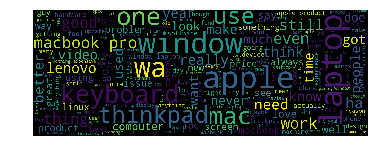

In [119]:
from vuepoint.vuepoint.Visualizers import make_wordcloud
make_wordcloud(dataset.text.values.tolist(), 'thinkpad_review')

In [120]:
from spacy.lang.en import stop_words

def get_most_frequent_words(df, text_column, N_words=20):
    common_words = pd.Series(' '.join(
        df[text_column]).lower().split()).value_counts()[:N_words]
    uncommon_words = pd.Series(' '.join(
        df[text_column]).lower().split()).value_counts()[-N_words:]
    return common_words, uncommon_words

# we will add custom stop words to stop_words with union
common_words, uncommon_words = get_most_frequent_words(dataset, text_column='text')
df_stopwords = set(stop_words.STOP_WORDS)
df_stopwords = df_stopwords.union(list(common_words.keys()))
df_stopwords = df_stopwords.union(list(uncommon_words.keys()))

In [121]:
from vuepoint.vuepoint.models_pipeline import process_words

def sent_to_words(sentences):
    for sent in sentences:
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True)
        yield(sent)

data_list = dataset.text.values.tolist()
data_words = list(sent_to_words(data_list))
data_ready = process_words(data_words, stop_words=df_stopwords)

In [122]:
from vuepoint.vuepoint import NgramFreq

NgramFreq.get_top_unigrams(data_list, topn=20)

[('apple', 6137),
 ('window', 5851),
 ('laptop', 5523),
 ('like', 3485),
 ('keyboard', 3196),
 ('macbook', 3192),
 ('mac', 3108),
 ('wa', 2713),
 ('use', 2695),
 ('one', 2516),
 ('year', 2407),
 ('pro', 2339),
 ('ha', 2176),
 ('thinkpad', 2149),
 ('get', 2107),
 ('would', 2047),
 ('still', 1911),
 ('work', 1867),
 ('better', 1812),
 ('video', 1771)]

In [123]:
NgramFreq.get_top_bigrams(data_list, topn=20)

[('macbook pro', 1432),
 ('window laptop', 553),
 ('apple product', 536),
 ('macbook air', 393),
 ('apple laptop', 383),
 ('year ago', 299),
 ('year old', 269),
 ('apple ha', 233),
 ('battery life', 214),
 ('gb ram', 213),
 ('use window', 213),
 ('last year', 206),
 ('dell xps', 204),
 ('go back', 192),
 ('build quality', 191),
 ('much better', 185),
 ('using window', 180),
 ('look like', 163),
 ('best laptop', 162),
 ('lenovo thinkpad', 150)]

In [124]:
NgramFreq.get_top_trigrams(data_list, topn=20)

[('using macbook pro', 67),
 ('new macbook pro', 59),
 ('huawei matebook pro', 58),
 ('mac book pro', 56),
 ('use macbook pro', 49),
 ('final cut pro', 45),
 ('never go back', 43),
 ('macbook pro keyboard', 43),
 ('smsung smsung smsung', 42),
 ('inch macbook pro', 38),
 ('best laptop ever', 37),
 ('go back window', 37),
 ('bought macbook pro', 36),
 ('switched macbook pro', 34),
 ('never looked back', 33),
 ('macbook pro inch', 32),
 ('macbook pro still', 31),
 ('gb ram gb', 30),
 ('quitting apple laptop', 30),
 ('macbook pro year', 29)]

In [125]:
id2word = corpora.Dictionary(data_ready)
corpus = [id2word.doc2bow(text) for text in data_ready]
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                            num_topics=4,
                                            random_state=100,
                                            update_every=1,
                                            chunksize=1000,
                                            passes=10,
                                            alpha='symmetric',
                                            iterations=50,
                                            per_word_topics=True)

pprint(lda_model.print_topics())

[(0,
  '0.029*"video" + 0.028*"product" + 0.021*"people" + 0.014*"know" + '
  '0.012*"buy" + 0.012*"time" + 0.011*"money" + 0.010*"problem" + '
  '0.010*"think" + 0.010*"good"'),
 (1,
  '0.027*"linux" + 0.016*"update" + 0.013*"macos" + 0.013*"run" + '
  '0.013*"software" + 0.011*"need" + 0.011*"pc" + 0.010*"user" + 0.010*"game" '
  '+ 0.010*"app"'),
 (2,
  '0.031*"key" + 0.012*"quit" + 0.011*"type" + 0.008*"button" + 0.008*"leave" '
  '+ 0.008*"comment" + 0.007*"mouse" + 0.006*"trackpad" + 0.006*"think" + '
  '0.006*"absolutely"'),
 (3,
  '0.025*"good" + 0.014*"buy" + 0.013*"look" + 0.013*"new" + 0.011*"price" + '
  '0.011*"great" + 0.009*"love" + 0.009*"lenovo" + 0.009*"old" + '
  '0.008*"thing"')]


In [126]:
from vuepoint.vuepoint import Vue
vuepoint = Vue()

In [127]:
topic_keywords = vuepoint.format_sent_topics(ldamodel=lda_model,
                                             corpus=corpus,
                                             texts=data_ready,
                                             n_topics=4)
dominant_topic = topic_keywords.reset_index()
dominant_topic.columns = ['doc_num', 'dominant_topic', 'topic_perc_contrib', 'key_words', 'text']
#dominant_topic.to_csv('huawei_4topic_model.csv')
dominant_topic.head()

,doc_num,dominant_topic,topic_perc_contrib,key_words,text
0,0,3.0,0.8387,"good, buy, look, new, price, great, love, leno...","[carbon, fan, time, ibm]"
1,1,0.0,0.8477,"video, product, people, know, buy, time, money...","[lew, budget, phone, redmi]"
2,2,0.0,0.7157,"video, product, people, know, buy, time, money...","[stop, phone, want, crazy, gadget, weird, gadg..."
3,3,3.0,0.6497,"good, buy, look, new, price, great, love, leno...","[check, new, asus, blown_away]"
4,4,1.0,0.7156,"linux, update, macos, run, software, need, pc,...","[unbox_therapy, strongly, recommend, carobon, ..."


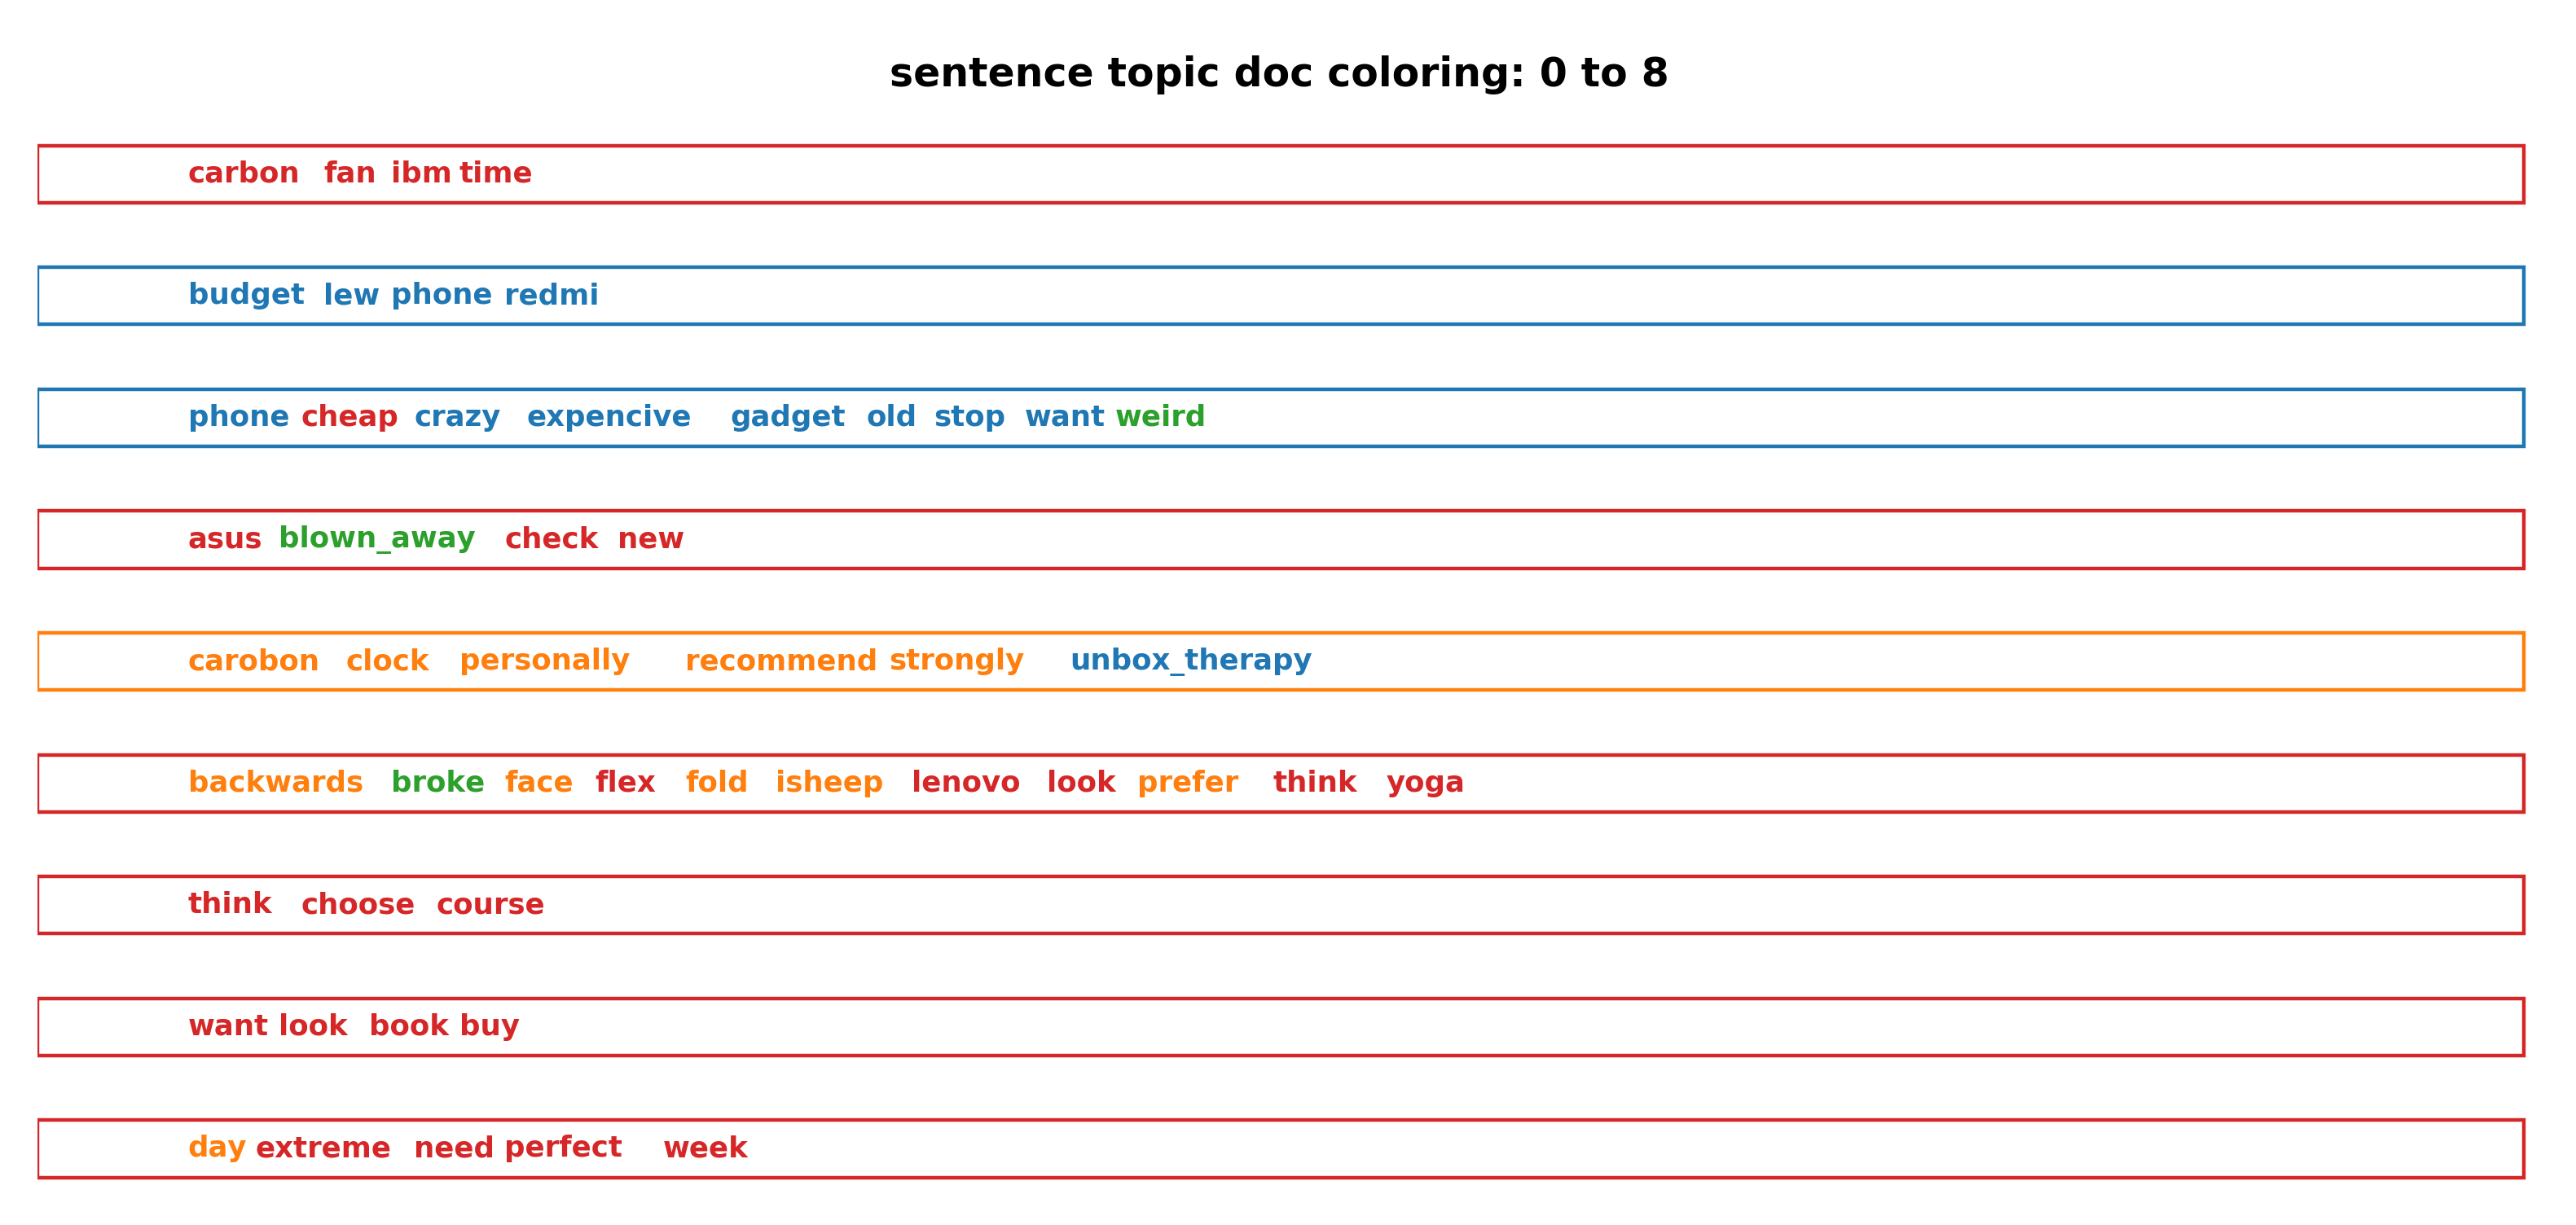

In [128]:
import matplotlib.pylab as plt
import matplotlib.colors as mcolors
from matplotlib.patches import Rectangle

def sentences_chart(lda_model=lda_model, corpus=corpus, start=0, end=10):
    # sentence coloring of number sentences
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]
    fig, axes = plt.subplots(end - start, 1,
                             figsize=(20, (end - start) * 0.95),
                             dpi=160)
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1]
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0])
                                  for wd, topic in wordid_topics]
            ax.text(0.01, 0.5,
                    "Doc " + str(i-1) + ": ",
                    verticalalignment='center',
                    fontsize=16,
                    color='white',
                    transform=ax.transAxes,
                    fontweight=700)
            # draw rectangle
            topic_percs_sorted = sorted(
                topic_percs, key=lambda x: (x[1]), reverse=True)
        
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90,
                                   fill=None,
                                   alpha=1,
                                   color=mycolors[topic_percs_sorted[0][0]],
                                   linewidth=2))
            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    # to move the word for the next iter
                    word_pos += .009 * len(word)
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16,
                    color='white',
                    transform=ax.transAxes)
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle(
        'sentence topic doc coloring: ' + str(start) + ' to ' + str(end-2),
        fontsize=22,
        y=0.95,
        fontweight=700
    )
    plt.tight_layout()
    plt.show()
sentences_chart()

In [129]:
import pyLDAvis
import pyLDAvis.gensim

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
pyLDAvis.save_html(vis, '4topics_thinkpad_review.html')

/home/ego/anaconda3/envs/ai/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [137]:
from multiprocessing import cpu_count

model = gensim.models.Word2Vec(size=100, 
                               window=10, 
                               min_count=5, 
                               sample=1e-4,
                               seed=1,
                               negative=5,
                               workers=cpu_count(), sg=1)
model.build_vocab(data_ready)
print('model vocab length: ', len(model.wv.vocab))
model.train(data_ready, total_examples=len(data_ready), epochs=400)

model vocab length:  3766


(40525561, 85059600)

In [141]:
model.wv.most_similar("expensive", topn=20)

[('price', 0.728131890296936),
 ('buy', 0.7144961357116699),
 ('product', 0.6384771466255188),
 ('good', 0.6287019848823547),
 ('money', 0.6240248680114746),
 ('compare', 0.6162467002868652),
 ('pay', 0.5928858518600464),
 ('new', 0.5924436450004578),
 ('people', 0.5868901014328003),
 ('cheap', 0.5839684009552002),
 ('brand', 0.5836582183837891),
 ('premium', 0.5800572633743286),
 ('spec', 0.5762805342674255),
 ('come', 0.5761620998382568),
 ('quality', 0.5690391063690186),
 ('cost', 0.5646544098854065),
 ('worth', 0.5586767196655273),
 ('doe', 0.556540310382843),
 ('air', 0.5479862689971924),
 ('long', 0.54448002576828)]

In [171]:
model.wv.most_similar("lenovo", topn=20)

[('carbon', 0.7194318771362305),
 ('good', 0.7112903594970703),
 ('old', 0.6882442831993103),
 ('buy', 0.6647865176200867),
 ('great', 0.6638999581336975),
 ('love', 0.6495233774185181),
 ('come', 0.64085853099823),
 ('model', 0.6282600164413452),
 ('new', 0.6253213882446289),
 ('think', 0.6213259100914001),
 ('day', 0.6204546689987183),
 ('thing', 0.6169297099113464),
 ('bad', 0.6006451845169067),
 ('probably', 0.5999245047569275),
 ('dell', 0.5983173251152039),
 ('right', 0.5894224643707275),
 ('cheap', 0.5894057750701904),
 ('feel', 0.5802701115608215),
 ('line', 0.5791426301002502),
 ('amazing', 0.579078197479248)]

In [150]:
model.wv.doesnt_match("thinkpad or apple is expensive".split())

'expensive'

In [36]:
model.wv.doesnt_match("is facebook is the worst app".split())

'app'

In [31]:
model.wv.doesnt_match("president trump is the best".split())

'best'

In [30]:
model.wv.doesnt_match("president trump is the worst".split())

'president'

In [159]:
smartphone_companies = ['apple', 'samsung', 'android', 'lg', 'sony', 'lenovo',
                        'microsoft', 'blackberry', 'motorola', 'xiaomi', 'huwai']

words = ['virus', 'safe', 'expensive', 'buying', 'slow',
         'hate', 'junk', 'cheap', 'best', 'ugly', 'stupid']

def brand_identity_association_by_word(words, brand_list):
    mosts_similar_associations =  model.wv.most_similar_to_given
    for word in words:
        identity_match = mosts_similar_associations(
            entity1=word, entities_list=brand_list
        )
        print(f"{word.upper()}: is associated to: {identity_match.upper()}")
        
brand_identity_association_by_word(words, smartphone_companies)

In [174]:
model.wv.most_similar("helpful", topn=20)

[('induce', 0.49902206659317017),
 ('dope', 0.4870578646659851),
 ('humor', 0.4004541039466858),
 ('professionally', 0.38766491413116455),
 ('border', 0.38720422983169556),
 ('advise', 0.3840918242931366),
 ('swipe', 0.38244345784187317),
 ('convincing', 0.3770957887172699),
 ('inherit', 0.3755197525024414),
 ('foundation', 0.37482261657714844),
 ('making', 0.37432926893234253),
 ('iam', 0.3720146417617798),
 ('standalone', 0.3717796504497528),
 ('colleague', 0.36874693632125854),
 ('thank_god', 0.3666416108608246),
 ('symbol', 0.3665836453437805),
 ('stubborn', 0.36567065119743347),
 ('color', 0.3648119866847992),
 ('trackball', 0.36360830068588257),
 ('index', 0.36332523822784424)]

In [179]:
x_, y_ = 'UgyJfojoBqKkMV-8c4B4AaABAg.8noVYyFRQar8np5WGpKyFl'.split('.')
print(f"user1 {x_} --> user2 {y_}")

user1 UgyJfojoBqKkMV-8c4B4AaABAg --> user2 8noVYyFRQar8np5WGpKyFl
